In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from scipy import stats
warnings.filterwarnings('ignore')
# reading raw data file
columns = ['user','activity','timestamp', 'x-axis', 'y-axis', 'z-axis']
df_har = pd.read_csv('WISDM_ar_v1.1/WISDM_ar_v1.1_raw.txt', header = None, names = columns, error_bad_lines=False)

FileNotFoundError: [Errno 2] No such file or directory: 'WISDM_ar_v1.1/WISDM_ar_v1.1_raw.txt'

In [ ]:
df_har.head()

,user,activity,timestamp,x-axis,y-axis,z-axis
0,33,Jogging,49105962326000,-0.694638,12.680544,0.50395286;
1,33,Jogging,49106062271000,5.012288,11.264028,0.95342433;
2,33,Jogging,49106112167000,4.903325,10.882658,-0.08172209;
3,33,Jogging,49106222305000,-0.612916,18.496431,3.0237172;
4,33,Jogging,49106332290000,-1.184970,12.108489,7.205164;


In [ ]:
df_har['activity'].unique()

array(['Jogging', 'Walking', 'Upstairs', 'Downstairs', 'Sitting',
       'Standing'], dtype=object)

In [ ]:
# removing null values
df_har = df_har.dropna()
df_har.shape
# transforming the z-axis to float
df_har['z-axis'] = df_har['z-axis'].str.replace(';', '')
df_har['z-axis'] = df_har['z-axis'].apply(lambda x:float(x))

In [ ]:
df = df_har[df_har['timestamp']!=0]
df = df_har.sort_values(by=['user', 'timestamp'], ignore_index=True)

In [ ]:
df['activity']

0           Walking
1           Walking
2           Walking
3           Walking
4           Walking
             ...   
1086460    Standing
1086461    Standing
1086462    Standing
1086463    Standing
1086464    Standing
Name: activity, Length: 1086465, dtype: object

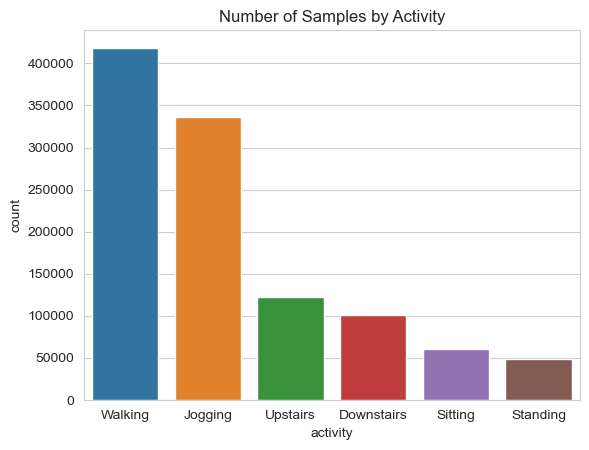

In [ ]:
sns.set_style("whitegrid")
sns.countplot(x='activity', data = df)
plt.title('Number of Samples by Activity')
plt.show()

In [ ]:
random_seed = 42
n_time_steps = 50
n_features = 3

step = 10

n_classes = 6
batch_size = 1024
n_epochs = 50
learning_rate = 0.0025
l2_loss = 0.0015

In [ ]:
print(df.shape)

(1086465, 6)


In [ ]:
segments = []
labels = []

for i in range (0, df.shape[0]-n_time_steps, step):
    xs = df['x-axis'].values[i: i+50]
    ys = df['y-axis'].values[i: i+50]
    zs = df['z-axis'].values[i: i+50]
    label = stats.mode(df['activity'][i: i+50])[0]
    segments.append([xs, ys, zs])
    labels.append(label)

In [ ]:
reshaped_segments = np.array(segments).reshape(-1, n_time_steps,n_features)

In [ ]:
print(f'reshaped segments={reshaped_segments}')

reshaped segments=[[[ 0.69       6.85       0.93     ]
  [-2.11      -4.59      12.41     ]
  [17.27       1.42      -2.68     ]
  ...
  [-4.21      -5.33       0.27     ]
  [-1.5       -1.33      -3.26     ]
  [10.88       6.51      -3.26     ]]

 [[ 1.57       4.02       4.94     ]
  [ 4.75       3.34       2.6      ]
  [ 7.31       8.43      10.53     ]
  ...
  [-2.68      -1.5       -1.84     ]
  [-0.38       1.38      -0.72     ]
  [-1.23      -0.84       6.66     ]]

 [[ 2.49      -1.12       0.       ]
  [ 7.16      -0.8       -5.13     ]
  [-3.17      19.57       7.08     ]
  ...
  [-0.65      -5.01      -6.82     ]
  [ 2.41      -0.99      -1.92     ]
  [-2.96       9.77       6.24     ]]

 ...

 [[-1.33      -1.33      -1.33     ]
  [-1.42      -1.38      -1.33     ]
  [-1.5       -1.33      -1.33     ]
  ...
  [ 2.3699405  2.3699405  2.4108016]
  [ 2.4516625  2.4108016  2.4516625]
  [ 2.4516625  2.4108016  2.4925237]]

 [[-1.46      -1.53      -1.53     ]
  [-1.42      -1.42

In [ ]:
from sklearn.preprocessing import OneHotEncoder

labels = np.array(labels).reshape(-1,1)
encoder = OneHotEncoder(sparse=False, dtype=np.float32)
labels_encoded = encoder.fit_transform(labels)

In [ ]:
print(labels_encoded)

[[0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 1.]
 ...
 [0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0. 0.]]


In [ ]:
reshaped_segments.shape

(108642, 50, 3)

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(reshaped_segments, labels_encoded, test_size=0.25, random_state= random_seed)

In [ ]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Flatten, Dropout

In [ ]:
X_train = np.array(X_train)

In [ ]:
print(X_train.shape)

(81481, 50, 3)


In [ ]:
model = Sequential()
# RNN layer
model.add(LSTM(units=128, input_shape=(X_train.shape[1], X_train.shape[2])))
# Dropout layer
model.add(Dropout(0.5))
# Dense layer with Relu
model.add(Dense(units=64, activation='relu'))
# softmax layer
model.add(Dense(y_train.shape[1], activation='softmax'))
# compile model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 128)               67584     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dense_1 (Dense)             (None, 6)                 390       
                                                                 
Total params: 76,230
Trainable params: 76,230
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = model.fit(X_train, y_train, epochs = n_epochs, validation_split = 0.25, batch_size = batch_size, verbose = 1)

Epoch 1/50
60/60 [==============================] - 30s 437ms/step - loss: 0.9601 - accuracy: 0.6604 - val_loss: 0.5822 - val_accuracy: 0.7961
Epoch 2/50
60/60 [==============================] - 25s 408ms/step - loss: 0.5449 - accuracy: 0.8069 - val_loss: 0.5042 - val_accuracy: 0.8179
Epoch 3/50
60/60 [==============================] - 37s 627ms/step - loss: 0.5052 - accuracy: 0.8196 - val_loss: 0.4648 - val_accuracy: 0.8306
Epoch 4/50
60/60 [==============================] - 45s 752ms/step - loss: 0.4568 - accuracy: 0.8346 - val_loss: 0.4319 - val_accuracy: 0.8415
Epoch 5/50
60/60 [==============================] - 44s 727ms/step - loss: 0.4228 - accuracy: 0.8450 - val_loss: 0.4211 - val_accuracy: 0.8439
Epoch 6/50
60/60 [==============================] - 45s 748ms/step - loss: 0.4005 - accuracy: 0.8548 - val_loss: 0.3679 - val_accuracy: 0.8629
Epoch 7/50
60/60 [==============================] - 45s 759ms/step - loss: 0.3719 - accuracy: 0.8637 - val_loss: 0.3628 - val_accuracy: 0.8696

In [ ]:
import pickle

with open('har_pickle', 'wb') as f:
    pickle.dump(model, f)

In [ ]:
with open('har_pickle', 'rb') as f:
    mp = pickle.load(f)

In [ ]:
predictions = mp.predict(X_test)

849/849 [==============================] - 12s 14ms/step


In [ ]:
print(predictions)

[[1.11141587e-02 4.82913293e-03 7.95884189e-05 6.78610304e-05
  6.44613728e-02 9.19447899e-01]
 [1.42133297e-06 4.36583059e-06 4.64552574e-09 3.22621307e-09
  2.36715937e-06 9.99991775e-01]
 [9.79062080e-01 2.82340217e-04 6.06314243e-05 4.72455395e-06
  1.08065205e-02 9.78363398e-03]
 ...
 [3.16883177e-01 5.94367087e-02 2.39894912e-02 4.14085202e-03
  4.57799435e-01 1.37750283e-01]
 [2.08001984e-05 3.48905596e-05 2.23393801e-08 2.00296686e-08
  1.28691781e-05 9.99931335e-01]
 [8.50115120e-01 8.67163239e-04 8.64963731e-05 8.94938603e-06
  1.44948393e-01 3.97382351e-03]]


In [ ]:
predictions.shape

(27161, 6)

In [ ]:
max_values = np.max(predictions, axis=1)
max_pos = np.argmax(predictions, axis=1)

max_prob = np.array(max_values)
cat_i = np.array(max_pos)

In [ ]:
print(f'max_prob={max_prob}')

max_prob=[0.9194479  0.9999918  0.9790621  ... 0.45779943 0.99993134 0.8501151 ]


In [ ]:
print(f'cat_i={cat_i}')

cat_i=[5 5 0 ... 4 5 0]


In [ ]:
cat = []
for i in range(0, 27161, 1):
    cat_a = ['Jogging', 'Walking', 'Upstairs', 'Downstairs', 'Sitting',
       'Standing']
    cat_ = cat_a[cat_i[i]]
    cat.append(cat_)
print(cat)

['Standing', 'Standing', 'Jogging', 'Sitting', 'Standing', 'Walking', 'Jogging', 'Walking', 'Standing', 'Walking', 'Sitting', 'Standing', 'Walking', 'Standing', 'Standing', 'Standing', 'Standing', 'Downstairs', 'Jogging', 'Sitting', 'Walking', 'Standing', 'Walking', 'Downstairs', 'Standing', 'Standing', 'Standing', 'Sitting', 'Sitting', 'Walking', 'Standing', 'Walking', 'Sitting', 'Standing', 'Walking', 'Walking', 'Standing', 'Walking', 'Walking', 'Standing', 'Standing', 'Walking', 'Walking', 'Standing', 'Standing', 'Upstairs', 'Standing', 'Walking', 'Standing', 'Jogging', 'Standing', 'Downstairs', 'Standing', 'Standing', 'Standing', 'Walking', 'Standing', 'Standing', 'Walking', 'Walking', 'Walking', 'Standing', 'Walking', 'Standing', 'Walking', 'Jogging', 'Jogging', 'Standing', 'Walking', 'Jogging', 'Jogging', 'Upstairs', 'Sitting', 'Walking', 'Standing', 'Sitting', 'Jogging', 'Standing', 'Standing', 'Standing', 'Standing', 'Jogging', 'Standing', 'Standing', 'Upstairs', 'Walking', 'Jo

In [ ]:
df = pd.DataFrame({'x':[-0.61291564],
                   'y': [18.496431],
                   'z': [3.0237172]
                   })

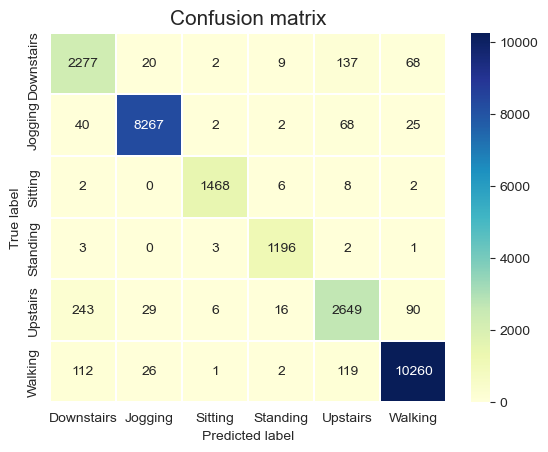

In [ ]:
from sklearn import metrics
class_labels = ['Downstairs', 'Jogging', 'Sitting', 'Standing', 'Upstairs', 'Walking']
max_test = np.argmax(y_test, axis=1)
max_predictions = np.argmax(predictions, axis=1)
confusion_matrix = metrics.confusion_matrix(max_test, max_predictions)
sns.heatmap(confusion_matrix, xticklabels = class_labels, yticklabels = class_labels, annot = True, linewidths = 0.1, fmt='d', cmap = 'YlGnBu')
plt.title("Confusion matrix", fontsize = 15)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [ ]:
def make_df(x, y, z):
    df = pd.DataFrame({'x':[x], 'y':[y], 'z': [z]})
    return df

In [ ]:
make_df()

In [ ]:
def predict_har(df):
    predicted_prob = model.predict(df)
    cat = np.argmax(predicted_prob)
    return cat